In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv

(H,W,3)= (720, 1280, 3)


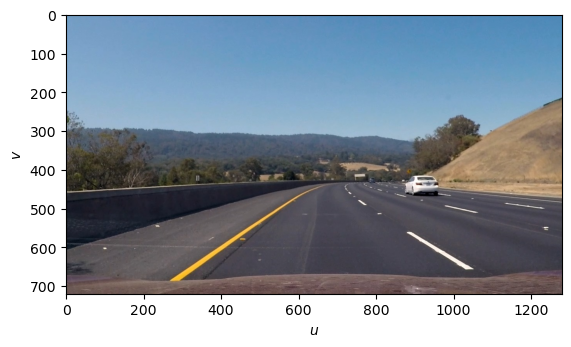

In [2]:
img = cv.imread("road.jpg")
# opencv (cv2) stores colors in the order blue, green, red, but we want red, green, blue
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img)
plt.xlabel("$u$") # horizontal pixel coordinate
plt.ylabel("$v$") # vertical pixel coordinate

print("(H,W,3)=",img.shape)

In [3]:
img[10, 20]

array([113, 155, 193], dtype=uint8)

In [4]:
# from fastseg import MobileV3Small
# model = MobileV3Small.from_pretrained()

In [5]:
# labels = model.predict_one(image)
# labels

In [6]:
# from fastseg.image import colorize, blend

# colorized = colorize(labels) # returns a PIL Image
# colorized.show()

In [7]:
# composited = blend(image, colorized) # returns a PIL Image
# composited.show()

In [8]:
import torch
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

def get_prediction(model, img_array):
    with torch.no_grad():
        image_tensor = img_array.transpose(2,0,1).astype('float32')/255
        x_tensor = torch.from_numpy(image_tensor).unsqueeze(0)
        out = F.softmax(model.forward(x_tensor), dim=1 )
        background, left, right = out[0,0,:,:], out[0,1,:,:], out[0,2,:,:]
    return background, left, right

In [9]:
# usage example:
model = torch.load("model.pth", map_location=torch.device('cpu'))
model.eval()
image = cv2.imread("road.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(720, 1280, 3)

In [10]:
background, left, right = get_prediction(model, image)
background.shape, left.shape, right.shape

(torch.Size([720, 1280]), torch.Size([720, 1280]), torch.Size([720, 1280]))

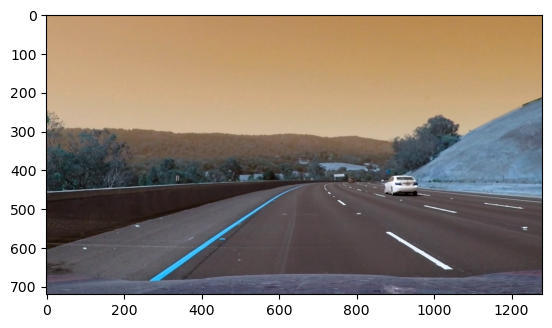

In [11]:
plt.imshow(image);

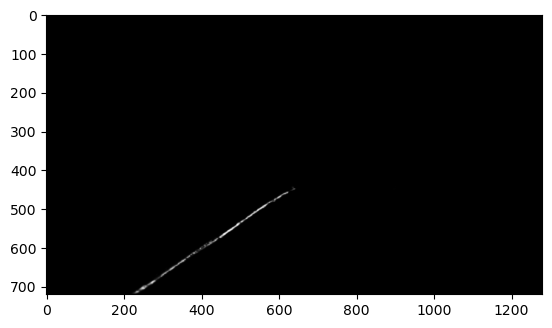

In [12]:
plt.imshow(left, cmap="gray");

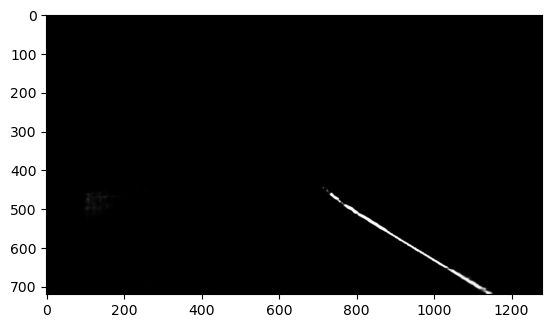

In [13]:
plt.imshow(right, cmap="gray");

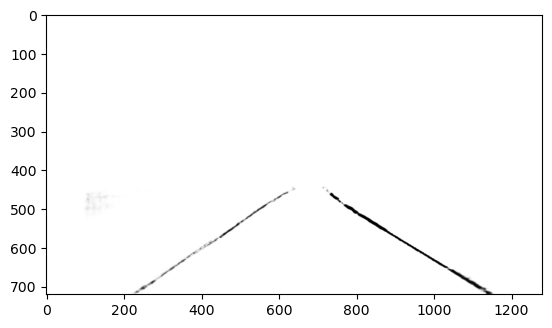

In [14]:
plt.imshow(background, cmap="gray");

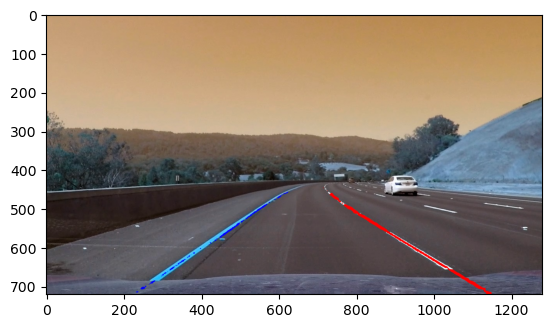

In [15]:
import copy

img_with_detection = copy.copy(image)
img_with_detection[left > 0.5, :] = [0,0,255] # blue
img_with_detection[right > 0.5, :] = [255,0,0] # red
plt.imshow(img_with_detection);

In [16]:
import torch
import numpy as np
from torchvision import models, transforms

import cv2
import time
from PIL import Image

In [17]:
def create_model(model_path="model.pth"):
    model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()

    return model

def create_video_capture(h=224, w=224, fps=36):
    vid_cap = cv2.VideoCapture(0, cv2.CAP_V4L2)
    vid_cap.set(cv2.CAP_PROP_FRAME_WIDTH, h)
    vid_cap.set(cv2.CAP_PROP_FRAME_HEIGHT, w)
    vid_cap.set(cv2.CAP_PROP_FPS, fps)

    return vid_cap

def create_preprocessor():
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return preprocess

In [18]:
def run_preds(model, vid_cap, preprocess, secs=10):
    started = time.time()
    last_logged = time.time()
    frame_count = 0
    frames_missed = 0

    with torch.no_grad():
        while (time.time() - started) < secs:
            # read frame
            ret, image = vid_cap.read()
            if not ret:
                frames_missed += 1
                print(f"[{frames_missed}]: failed to read frame")
                continue

            # convert opencv output from BGR to RGB
            image = image[:, :, [2, 1, 0]]

            # preprocess
            input_tensor = preprocess(image)

            # create a mini-batch as expected by the model
            input_batch = input_tensor.unsqueeze(0)

            # run model
            out = F.softmax(model(input_batch), dim=1)
            background, left, right = out[0,0,:,:], out[0,1,:,:], out[0,2,:,:]

            # log model performance
            frame_count += 1
            now = time.time()
            if now - last_logged > 1:
                print(f"{frame_count / (now-last_logged)} fps")
                last_logged = now
                frame_count = 0

In [19]:
model = create_model()
vid_cap = create_video_capture()
preprocess = create_preprocessor()
run_preds(model, vid_cap, preprocess, secs=0.001)

[1]: failed to read frame
[2]: failed to read frame
[3]: failed to read frame
[4]: failed to read frame
[5]: failed to read frame
[6]: failed to read frame
[7]: failed to read frame
[8]: failed to read frame
[9]: failed to read frame
[10]: failed to read frame
[11]: failed to read frame
[12]: failed to read frame
[13]: failed to read frame
[14]: failed to read frame
[15]: failed to read frame
[16]: failed to read frame
[17]: failed to read frame
[18]: failed to read frame
[19]: failed to read frame
[20]: failed to read frame
[21]: failed to read frame
[22]: failed to read frame
[23]: failed to read frame
[24]: failed to read frame
[25]: failed to read frame


[ WARN:0@11.742] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ WARN:0@11.742] global cap.cpp:342 open VIDEOIO(V4L2): backend is generally available but can't be used to capture by index


In [22]:
from torchvision import models

m = models.mobilenet_v3_small()